# Clustering Demo

## Set-up

### Load modules

In [118]:
import os # module for interacting with files and folders
from audio_processing import *
from audio_display import *
from array_manipulation import *
from load_audio import *
from feature_normalize import *
from pca_paths import *
from frame_clustering import *
from segments import *
from time_series import *
from bespoke_segmentation import *

### Load Audio Files

In [119]:
paths = [r'sound/American-English/Narrative',
        r'sound/American-English/Consonants',
        r'sound/American-English/Vowels',
        r'sound/Non-speech']

out_path = 'sound/out/'

fns = []
audio_data = []
fns,audio_data = load_audio(paths_list=paths, pad=0,nonspeech_dur=0)

narrative_fns,consonants_fns,vowels_fns,nonspeech_fns = fns
narrative_data,consonants_data,vowels_data,nonspeech_data = audio_data

### Normalization from Narrative Data

In [143]:
narrative_fns = sorted(narrative_fns)
narrative_data = sorted(narrative_data,key = lambda x: x["fn"])
narr = get_narr(narrative_fns,pad=0)
narr_scaler = get_scaler(narrative_fns)

narr_mfcc = norm_array_hor(narr,narr_scaler)
narr_frames = np.transpose(narr_mfcc)

narr_fourier = get_narr(narrative_fns,get_fourier=True,pad=0)

print(narr_frames.shape)
print(narr_fourier.shape)

(9549, 12)
(1025, 9549)


['Bird', 'Bed', 'Bid', 'Above', 'Bayed', 'Good', 'Buy', 'Bud', 'Bead', 'Bough', 'Bad', 'Boy', 'Booed', 'Bode', 'Pod', 'Sigh', 'Shy', 'Fie', 'Rye', 'Die', 'Why', 'Hang', 'Guy', 'Thigh', 'You', 'Thy', 'Gin', 'Vie', 'My', 'Azure', 'Tie', 'High', 'Pie', 'Kite', 'Chin', 'Lie', 'Nigh', 'Zoo']


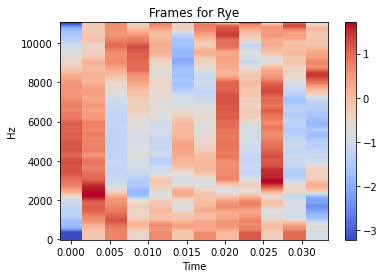

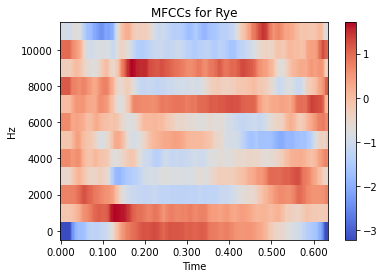

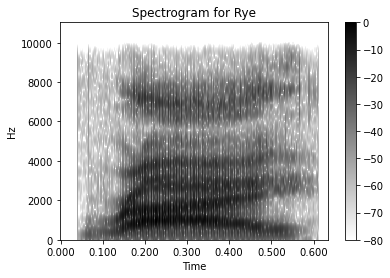

In [121]:
sig_figs = 3

clip_dict = {}
path_test_fns = vowels_fns+consonants_fns+nonspeech_fns

for clip_fn in path_test_fns:
  name = clip_fn.split("/")[-1].split(".")[0].title()
  clip_data = process_audio(clip_fn,n_mfcc_list=[12],pad = 0)
  fourier = clip_data["fourier"]
  sr = clip_data["sr"]
  ts = clip_data["ts"]
  normed_mfcc = norm_array_hor(clip_data["mfcc"]["12"],narr_scaler)
  clip_frames = np.transpose(normed_mfcc)
  clip_dict[name] = {"frames":clip_frames,"mfcc":normed_mfcc,"fourier":fourier,"ts":ts}

all_words = list(clip_dict.keys())
all_words.remove('Train')
all_words.remove('Water')
print(all_words)

res = 3
hop = 2**(9-res)
w = hop/sr


word = "Rye"

frame_title = "Frames for "+word
mfcc_title = "MFCCs for "+word
fourier_title = "Spectrogram for "+word

plot_mfcc(clip_dict[word]["frames"],sr=sr,title=frame_title)
plot_mfcc(clip_dict[word]["mfcc"],sr=sr,title=mfcc_title)
plot_spectrogram(clip_dict[word]["fourier"],sr=sr,title=fourier_title)

out_path = 'sound/out/'
export_audio_from_timeseries(out_path+word+"_clip.wav",clip_dict[word]["ts"],sr)
Audio(out_path+word+"_clip.wav")

## K-means Clustering

### Clustering on Narrative

In [122]:
number_of_clusters = 4

common_params = {
    "n_init": 10,
    "random_state": 170,
}

kmeans_clusters = KMeans(n_clusters=number_of_clusters, **common_params).fit(narr_frames)
y_pred = kmeans_clusters.predict(narr_frames)
kmeans_clustering = list(y_pred)
kmeans_narr_seg = get_intervals(kmeans_clustering,frame_w=w)
kmeans_narr_seg_split = split_frames(kmeans_narr_seg,narr_frames)

print(f"Length of narrative: {round(len(narr_frames)*w,2)}s")
print(f"Length of segmentation: {len(kmeans_narr_seg)} intervals")
print(f"Number of labels: {len(set([seg['text'] for seg in kmeans_narr_seg]))}")

seg_lengths = [1000*w*frames.shape[0] for frames in kmeans_narr_seg_split]
seg_length_set = sorted(list(set(seg_lengths)))
seg_length_count = [seg_lengths.count(l) for l in seg_length_set]
print(f'Segment lengths: {" ".join([str(int(round(l,0)))+"ms("+str(n)+")" for l,n in zip(seg_length_set,seg_length_count)])}')

#plot_segments_on_mfcc(narr_mfcc,kmeans_narr_seg,sr,title=f" segmentation ",line_color='black')
#plot_segments_on_spectrogram(narr_fourier,kmeans_narr_seg,sr,title=f" segmentation ",line_color='black')

Length of narrative: 27.72s
Length of segmentation: 407 intervals
Number of labels: 4
Segment lengths: 3ms(9) 6ms(13) 9ms(12) 12ms(10) 15ms(11) 17ms(23) 20ms(15) 23ms(14) 26ms(15) 29ms(16) 32ms(15) 35ms(7) 38ms(6) 41ms(13) 44ms(11) 46ms(7) 49ms(7) 52ms(3) 55ms(5) 58ms(8) 61ms(8) 64ms(5) 67ms(8) 70ms(4) 73ms(8) 75ms(3) 78ms(7) 81ms(7) 84ms(5) 87ms(7) 90ms(6) 93ms(9) 96ms(2) 99ms(7) 102ms(4) 104ms(7) 107ms(3) 110ms(6) 113ms(4) 116ms(3) 119ms(2) 122ms(2) 125ms(6) 128ms(3) 131ms(2) 134ms(6) 136ms(6) 139ms(3) 142ms(5) 145ms(4) 148ms(3) 151ms(2) 154ms(3) 157ms(2) 160ms(2) 165ms(3) 171ms(2) 174ms(1) 177ms(1) 180ms(1) 192ms(1) 194ms(1) 206ms(2) 209ms(1) 218ms(1) 221ms(1) 238ms(1) 258ms(1) 261ms(1) 267ms(1) 270ms(1) 282ms(1) 296ms(1) 337ms(1)


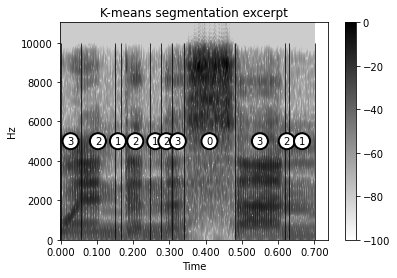

In [123]:
start_seg = 10
end_seg = 20

start_frame = kmeans_narr_seg[start_seg]["fmin"]
end_frame = kmeans_narr_seg[end_seg]["fmax"]

trimmed_mfcc = np.split(narr_mfcc,[start_frame,end_frame],axis = 1)[1]
trimmed_fourier = np.split(narr_fourier,[start_frame,end_frame],axis = 1)[1]
trimmed_segmentation = copy.deepcopy(kmeans_narr_seg[start_seg:end_seg+1])
for interval in trimmed_segmentation:
    interval["fmin"] -= start_frame
    interval["fmax"] -= start_frame
    interval["tmin"] -= start_frame*w
    interval["tmax"] -= start_frame*w


#plot_segments_on_mfcc(trimmed_mfcc,trimmed_segmentation,sr,title=f" segmentation ",line_color='black')
plot_segments_on_spectrogram(trimmed_fourier,trimmed_segmentation,sr,title=f"K-means segmentation excerpt",line_color='black')

out_path = 'sound/out/'
ts = get_audio_data(narrative_fns[0], dur = (end_frame-start_frame)*w, offset = start_frame*w)["ts"]
export_audio_from_timeseries(out_path+"narr_clip.wav",ts,sr)
Audio(out_path+"narr_clip.wav")

### Clustering on Single Words

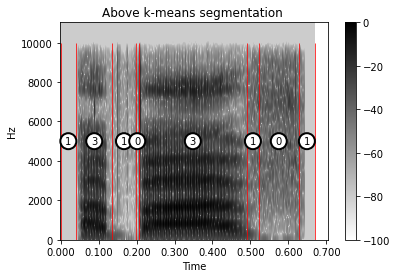

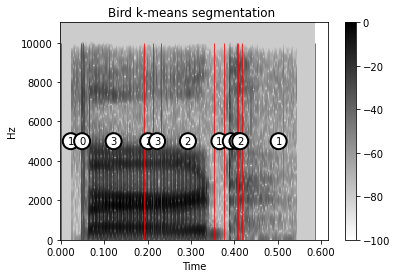

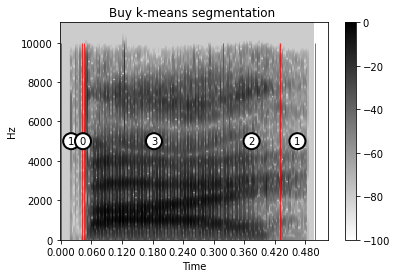

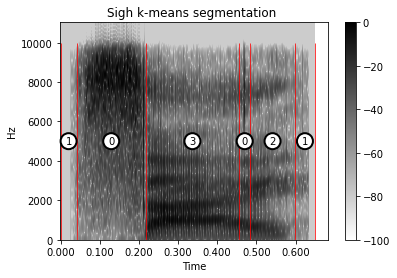

In [124]:
kmeans_segs = {}

for word in all_words:
    clip = clip_dict[word]
    frames = clip["frames"]
    y_pred = kmeans_clusters.predict(frames)
    clustering = list(y_pred)
    segmentation = get_intervals(clustering,frame_w=w)
    kmeans_segs[word] = segmentation

some_words = ["Above", "Bird", "Buy", "Sigh"]
#some_words = ['Above', 'Azure', 'Kite', 'Chin']
#some_words = ['Buy','Sigh','Shy','Fie']
for word in some_words:
    #plot_segments_on_mfcc(clip_dict[word]["mfcc"],kmeans_segs[word],sr,title=f"{word} segmentation ",line_color='black')
    plot_segments_on_spectrogram(clip_dict[word]["fourier"],kmeans_segs[word],sr,title=f"{word} k-means segmentation ",line_color='red')

## Pruning with Recurrence Score

### Generate Bouquets

#### Segmentation

Length of narrative: 27.72s
Length of segmentation: 554 intervals
Number of labels: 554
Segment lengths: 49ms(428) 52ms(126)


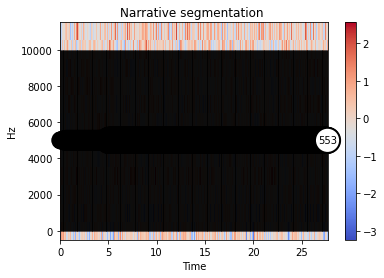

In [125]:
narr_len = len(narr_frames)

even_seg = get_even_segments(narr_len,frame_w=w,seg_ms=50,clip_last = False)
even_seg_split = split_frames(even_seg,narr_frames)

print(f"Length of narrative: {round(len(narr_frames)*w,2)}s")
print(f"Length of segmentation: {len(even_seg)} intervals")
print(f"Number of labels: {len(set([seg['text'] for seg in even_seg]))}")

seg_lengths = [1000*w*frames.shape[0] for frames in even_seg_split]
seg_length_set = sorted(list(set(seg_lengths)))
seg_length_count = [seg_lengths.count(l) for l in seg_length_set]
print(f'Segment lengths: {" ".join([str(int(round(l,0)))+"ms("+str(n)+")" for l,n in zip(seg_length_set,seg_length_count)])}')

plot_segments_on_mfcc(np.transpose(narr_frames),even_seg,sr,title=f"Narrative segmentation ",line_color='black',complete = False)

#### [2,3] Bouquet


In [126]:
n_iter = [2,3]

narr_bouquet = get_bouquet(even_seg,n_iter=n_iter,text_method = 'count')
narr_bouquet_split = split_frames(narr_bouquet,narr_frames)

print(f'Number of intervals in bouquet: {len(narr_bouquet)}')
for i in [1,2,3,4,5]:
    print(f'Number of {i}-segment intervals: {len([s for s in narr_bouquet if s["text"] == str(i)])}')



seg_lengths = [1000*w*frames.shape[0] for frames in narr_bouquet_split]
seg_length_set = sorted(list(set(seg_lengths)))
seg_length_count = [seg_lengths.count(l) for l in seg_length_set]
print(f'Segment lengths: {" ".join([str(int(round(l,0)))+"ms("+str(n)+")" for l,n in zip(seg_length_set,seg_length_count)])}')

Number of intervals in bouquet: 1105
Number of 1-segment intervals: 0
Number of 2-segment intervals: 553
Number of 3-segment intervals: 552
Number of 4-segment intervals: 0
Number of 5-segment intervals: 0
Segment lengths: 99ms(302) 102ms(251) 148ms(176) 151ms(376)


## Pruning

#### Pruning K-means Segmentations

Round 1 of pruning complete.
Round 2 of pruning complete.
Pruned segmentation for Above complete (8->7 intervals)


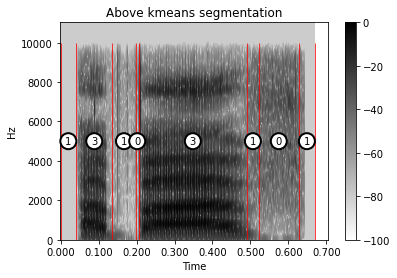

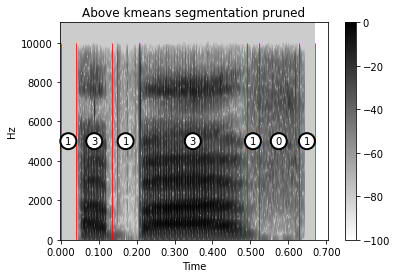

In [127]:
word = "Above"
clip = clip_dict[word]

kmeans_seg = kmeans_segs[word]
pruned_seg = recurrence_prune(kmeans_seg,clip["frames"],narr_bouquet_split,zeal=1.05,text_method='longest',show_progress=True)
print(f'Pruned segmentation for {word} complete ({len(kmeans_seg)}->{len(pruned_seg)} intervals)')

plot_segments_on_spectrogram(clip["fourier"],kmeans_seg,sr,title=f"{word} kmeans segmentation",line_color='red')
plot_segments_on_spectrogram(clip["fourier"],pruned_seg,sr,title=f"{word} kmeans segmentation pruned",line_color='red')

In [128]:
pruned_kmeans_segs = {}

for word in all_words:
    clip = clip_dict[word]
    kmeans_seg = kmeans_segs[word]
    pruned_seg = recurrence_prune(kmeans_seg,clip["frames"],narr_bouquet_split,zeal=1.05,text_method='longest')
    pruned_kmeans_segs[word] = pruned_seg
    print(f'Pruned segmentation for {word} complete ({len(kmeans_seg)}->{len(pruned_seg)} intervals)')

Pruned segmentation for Bird complete (11->7 intervals)
Pruned segmentation for Bed complete (11->8 intervals)


KeyboardInterrupt: 

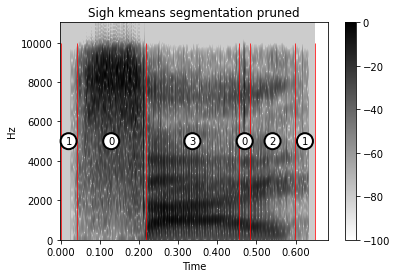

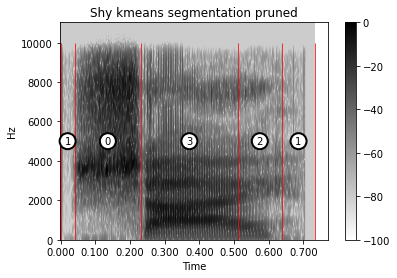

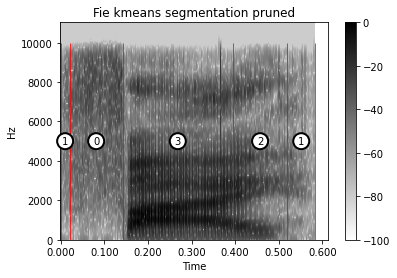

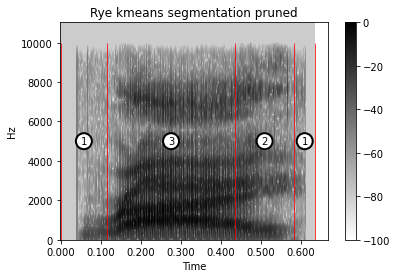

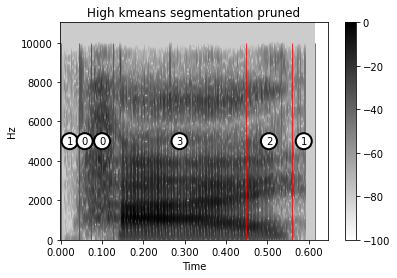

In [110]:
#some_words = ["Above", "Bird", "Buy", "Sigh"]
#some_words = ['Above', 'Azure', 'Kite', 'Chin']
some_words = ['Sigh','Shy','Fie','Rye','High']
for word in some_words:
    clip = clip_dict[word]
    #plot_segments_on_spectrogram(clip["fourier"],kmeans_segs[word],sr,title=f"{word} kmeans segmentation",line_color='red')
    plot_segments_on_spectrogram(clip["fourier"],pruned_kmeans_segs[word],sr,title=f"{word} kmeans segmentation pruned",line_color='red')

## Better Bouquets

### Baseline Bouquets

#### Sub-narritives

In [144]:
for i,file in enumerate(narrative_data):
    print(str(i),file["fn"],str(file["dur"]))

0 sound/American-English/Narrative/narrative1.wav 5.366712018140589
1 sound/American-English/Narrative/narrative2.wav 6.224126984126984
2 sound/American-English/Narrative/narrative3.wav 6.110294784580499
3 sound/American-English/Narrative/narrative4.wav 2.191519274376417
4 sound/American-English/Narrative/narrative5.wav 3.7996825396825398
5 sound/American-English/Narrative/narrative6.wav 4.010702947845805


In [132]:
sub_narrs = []
sub_narrs_mfcc = []
sub_narrs_frames = []
sub_narrs_fourier = []
for i in range(len(narrative_fns)):
    sub_narr_fns = narrative_fns[:i]+narrative_fns[i+1:]
    sub_narr = get_narr(sub_narr_fns,pad=0)
    sub_narrs.append(sub_narr)
    sub_narrs_mfcc.append(norm_array_hor(sub_narr,narr_scaler))
    sub_narrs_frames.append(np.transpose(sub_narrs_mfcc[-1]))
    sub_narrs_fourier.append(get_narr(sub_narr_fns,get_fourier=True,pad=0))

In [141]:
for i,thing in enumerate(sub_narrs):
    print(f'#{i}: {w*sub_narrs_frames[i].shape[0]}')

#0: 22.346303854875284
#1: 21.490068027210885
#2: 21.60326530612245
#3: 25.521632653061225
#4: 23.913650793650795
#5: 23.704671201814058


#### [2,3] Bouquets from sub-narratives

In [ ]:
n_iter = [2,3]

sub_narr_bouquets = []
sub_narr_bouquets_split = []
for i,sub_narr in enumerate(sub_narrs):
    sub_narr_len = sub_narrs_frames[i].shape[0]
    print(sub_narr_len)
    sub_narr_even_seg = get_even_segments(sub_narr_len,frame_w=w,seg_ms=100,clip_last = False)
    sub_narr_even_seg_split = split_frames(sub_narr_even_seg,sub_narrs_frames[i])
    sub_narr_bouquet = get_bouquet(sub_narr_even_seg,n_iter=n_iter,text_method = 'count')
    sub_narr_bouquet_split = split_frames(sub_narr_bouquet,narr_frames)
    sub_narr_bouquets.append(sub_narr_bouquet)
    sub_narr_bouquets_split.append(sub_narr_bouquet_split)
    print(f'Number of intervals in bouquet: {len(sub_narr_bouquet)}')
    for i in [2,3]:
        print(f'Number of {i}-segment intervals: {len([s for s in sub_narr_bouquet if s["text"] == str(i)])}')
    seg_lengths = [1000*w*frames.shape[0] for frames in sub_narr_bouquet_split]
    seg_length_set = sorted(list(set(seg_lengths)))
    seg_length_count = [seg_lengths.count(l) for l in seg_length_set]
    print(f'Segment lengths: {" ".join([str(int(round(l,0)))+"ms("+str(n)+")" for l,n in zip(seg_length_set,seg_length_count)])}')

Number of intervals in bouquet: 443
Number of 2-segment intervals: 222
Number of 3-segment intervals: 221
Segment lengths: 197ms(20) 200ms(202) 299ms(141) 302ms(80)
Number of intervals in bouquet: 425
Number of 2-segment intervals: 213
Number of 3-segment intervals: 212
Segment lengths: 197ms(19) 200ms(194) 299ms(135) 302ms(77)
Number of intervals in bouquet: 429
Number of 2-segment intervals: 215
Number of 3-segment intervals: 214
Segment lengths: 197ms(20) 200ms(195) 299ms(137) 302ms(77)
Number of intervals in bouquet: 507
Number of 2-segment intervals: 254
Number of 3-segment intervals: 253
Segment lengths: 197ms(23) 200ms(231) 299ms(161) 302ms(92)
Number of intervals in bouquet: 475
Number of 2-segment intervals: 238
Number of 3-segment intervals: 237
Segment lengths: 197ms(22) 200ms(216) 299ms(152) 302ms(85)
Number of intervals in bouquet: 471
Number of 2-segment intervals: 236
Number of 3-segment intervals: 235
Segment lengths: 197ms(22) 200ms(214) 299ms(151) 302ms(84)


### Better Bouquet

#### Pruned K-means Segmentation

In [ ]:
number_of_clusters = 4

common_params = {
    "n_init": 10,
    "random_state": 170,
}

narr_clips_frames = []
kmeans_narr_clip_segs = []
kmeans_narr_clip_segs_split = []

for narr_clip in narrative_data:
    narr_clip_frames = np.transpose(narr_clip["mfcc"]["12"])
    kmeans_clusters = KMeans(n_clusters=number_of_clusters, **common_params).fit(narr_clip_frames)
    y_pred = kmeans_clusters.predict(narr_clip_frames)
    kmeans_clustering = list(y_pred)
    kmeans_narr_clip_seg = get_intervals(kmeans_clustering,frame_w=w)
    kmeans_narr_clip_seg_split = split_frames(kmeans_narr_clip_seg,narr_clip_frames)

    narr_clips_frames.append(narr_clip_frames)
    kmeans_narr_clip_segs.append(kmeans_narr_clip_seg)
    kmeans_narr_clip_segs_split.append(kmeans_narr_clip_seg_split)

    print(f"Length of narrative: {round(len(narr_clip_frames)*w,2)}s")
    print(f"Length of segmentation: {len(kmeans_narr_clip_seg)} intervals")
    print(f"Number of labels: {len(set([seg['text'] for seg in kmeans_narr_clip_seg]))}")

    seg_lengths = [1000*w*frames.shape[0] for frames in kmeans_narr_clip_seg_split]
    seg_length_set = sorted(list(set(seg_lengths)))
    seg_length_count = [seg_lengths.count(l) for l in seg_length_set]
    print(f'Segment lengths: {" ".join([str(int(round(l,0)))+"ms("+str(n)+")" for l,n in zip(seg_length_set,seg_length_count)])}')

Length of narrative: 5.37s
Length of segmentation: 98 intervals
Number of labels: 4
Segment lengths: 3ms(4) 6ms(5) 9ms(2) 12ms(4) 15ms(6) 17ms(4) 20ms(2) 23ms(6) 26ms(2) 29ms(3) 32ms(3) 35ms(3) 38ms(4) 44ms(3) 46ms(2) 49ms(2) 52ms(4) 55ms(2) 58ms(3) 61ms(2) 64ms(2) 70ms(2) 73ms(2) 75ms(2) 78ms(1) 81ms(2) 93ms(1) 99ms(2) 102ms(1) 104ms(2) 113ms(2) 122ms(1) 125ms(1) 131ms(2) 134ms(1) 136ms(1) 142ms(1) 145ms(1) 148ms(1) 157ms(1) 160ms(1) 165ms(1) 174ms(1)
Length of narrative: 6.11s
Length of segmentation: 119 intervals
Number of labels: 4
Segment lengths: 3ms(5) 6ms(5) 9ms(4) 12ms(2) 15ms(7) 17ms(5) 20ms(6) 23ms(6) 26ms(5) 29ms(9) 32ms(4) 35ms(3) 38ms(4) 41ms(4) 44ms(3) 46ms(5) 49ms(2) 55ms(3) 61ms(2) 64ms(1) 67ms(3) 70ms(1) 75ms(3) 81ms(1) 87ms(2) 93ms(2) 96ms(3) 99ms(3) 102ms(1) 107ms(1) 110ms(1) 113ms(1) 125ms(1) 134ms(1) 139ms(2) 142ms(1) 151ms(2) 160ms(1) 163ms(2) 165ms(1) 226ms(1)
Length of narrative: 6.23s
Length of segmentation: 104 intervals
Number of labels: 4
Segment lengths: 3

In [ ]:
pruned_kmeans_narr_clip_segs = []
pruned_kmeans_narr_clip_segs_split = []

for i,kmeans_narr_clip_seg in enumerate(kmeans_narr_clip_segs):
    pruned_kmeans_narr_clip_seg = recurrence_prune(kmeans_narr_clip_seg,narr_clips_frames[i],sub_narr_bouquets_split[i],zeal=1.05,text_method='longest',show_progress=True)
    pruned_kmeans_narr_clip_seg_split = split_frames(pruned_kmeans_narr_clip_seg,narr_clips_frames[i])

    pruned_kmeans_narr_clip_segs.append(pruned_kmeans_narr_clip_seg)
    pruned_kmeans_narr_clip_segs_split.append(pruned_kmeans_narr_clip_seg_split)

    print(f"Length of narrative: {round(len(narr_clips_frames[i])*w,2)}s")
    print(f"Length of segmentation: {len(pruned_kmeans_narr_clip_seg)} intervals")
    print(f"Number of labels: {len(set([seg['text'] for seg in pruned_kmeans_narr_clip_seg]))}")

    seg_lengths = [1000*w*frames.shape[0] for frames in pruned_kmeans_narr_clip_seg_split]
    seg_length_set = sorted(list(set(seg_lengths)))
    seg_length_count = [seg_lengths.count(l) for l in seg_length_set]
    print(f'Segment lengths: {" ".join([str(int(round(l,0)))+"ms("+str(n)+")" for l,n in zip(seg_length_set,seg_length_count)])}')

Round 1 of pruning complete.
Round 2 of pruning complete.
Round 3 of pruning complete.
Round 4 of pruning complete.
Round 5 of pruning complete.
Length of narrative: 5.37s
Length of segmentation: 47 intervals
Number of labels: 4
Segment lengths: 32ms(1) 35ms(1) 38ms(1) 41ms(1) 55ms(1) 61ms(2) 70ms(1) 73ms(2) 75ms(1) 81ms(4) 84ms(2) 93ms(1) 99ms(2) 102ms(2) 110ms(2) 113ms(1) 116ms(3) 128ms(2) 131ms(1) 136ms(1) 139ms(1) 142ms(2) 145ms(1) 148ms(1) 157ms(1) 160ms(2) 165ms(1) 183ms(1) 186ms(1) 197ms(1) 203ms(1) 209ms(1) 229ms(1)
Round 1 of pruning complete.
Round 2 of pruning complete.
Round 3 of pruning complete.
Round 4 of pruning complete.
Round 5 of pruning complete.
Round 6 of pruning complete.
Round 7 of pruning complete.
Length of narrative: 6.11s
Length of segmentation: 49 intervals
Number of labels: 4
Segment lengths: 35ms(1) 41ms(1) 46ms(1) 49ms(2) 61ms(2) 64ms(1) 67ms(2) 90ms(1) 96ms(4) 99ms(3) 102ms(1) 104ms(1) 107ms(1) 110ms(3) 122ms(1) 125ms(2) 134ms(2) 136ms(1) 139ms(2) 142ms

In [ ]:
for narr_clip_seg in pruned_kmeans_narr_clip_segs:
    print((narr_clip_seg[1]["tmin"],narr_clip_seg[-2]["tmax"]))

(0.08126984126984127, 5.253514739229025)
(10.739229024943317, 16.564535147392295)
(28.009070294784564, 33.921451247165535)
(51.37995464852606, 55.161904761904744)
(76.44589569160995, 79.98403628117909)
(104.9367800453516, 106.77696145124729)


In [ ]:
combined_narr_seg = []
for narr_clip_seg in pruned_kmeans_narr_clip_segs:
    if combined_narr_seg == []:
        fshift = 0
    else:
        fshift = combined_narr_seg[-1]["fmax"] - narr_clip_seg[0]["fmin"]
    print(fshift)
    for interval in narr_clip_seg:
        interval["fmin"] += fshift
        interval["fmax"] += fshift
        interval["tmin"] += fshift*w
        interval["tmax"] += fshift*w
    combined_narr_seg.extend(narr_clip_seg)

combined_narr_seg_split = split_frames(combined_narr_seg,narr_frames)

print(f"Length of narrative: {round(len(narr_frames)*w,2)}s")
print(f"Length of segmentation: {len(combined_narr_seg)} intervals")
print(f"Number of labels: {len(set([seg['text'] for seg in combined_narr_seg]))}")

seg_lengths = [1000*w*frames.shape[0] for frames in combined_narr_seg_split]
seg_length_set = sorted(list(set(seg_lengths)))
seg_length_count = [seg_lengths.count(l) for l in seg_length_set]
print(f'Segment lengths: {" ".join([str(int(round(l,0)))+"ms("+str(n)+")" for l,n in zip(seg_length_set,seg_length_count)])}')

0
-1794
-5625
-11549
-18800
-27281
Length of narrative: 27.72s
Length of segmentation: 223 intervals
Number of labels: 4
Segment lengths: 17ms(1) 32ms(3) 35ms(2) 38ms(1) 41ms(2) 46ms(2) 49ms(2) 55ms(3) 58ms(2) 61ms(5) 64ms(2) 67ms(6) 70ms(3) 73ms(7) 75ms(4) 78ms(2) 81ms(9) 84ms(4) 87ms(3) 90ms(1) 93ms(2) 96ms(6) 99ms(7) 102ms(8) 104ms(7) 107ms(2) 110ms(7) 113ms(4) 116ms(5) 119ms(3) 122ms(6) 125ms(3) 128ms(6) 131ms(2) 134ms(4) 136ms(5) 139ms(5) 142ms(7) 145ms(2) 148ms(3) 151ms(5) 154ms(1) 157ms(4) 160ms(5) 163ms(3) 165ms(1) 168ms(2) 171ms(1) 174ms(2) 177ms(2) 183ms(5) 186ms(2) 189ms(2) 192ms(1) 194ms(2) 197ms(3) 200ms(4) 203ms(3) 206ms(1) 209ms(3) 212ms(1) 215ms(1) 221ms(1) 223ms(1) 226ms(2) 229ms(2) 232ms(1) 244ms(1) 255ms(1) 258ms(1) 316ms(1)


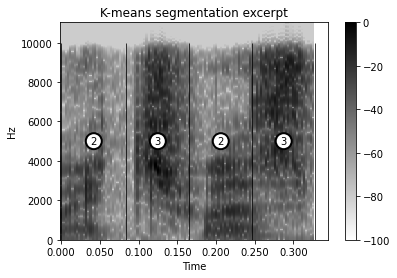

In [ ]:
start_seg = 16
end_seg = 19

start_frame = combined_narr_seg[start_seg]["fmin"]
end_frame = combined_narr_seg[end_seg]["fmax"]

trimmed_mfcc = np.split(narr_mfcc,[start_frame,end_frame],axis = 1)[1]
trimmed_fourier = np.split(narr_fourier,[start_frame,end_frame],axis = 1)[1]
trimmed_segmentation = copy.deepcopy(combined_narr_seg[start_seg:end_seg+1])
for interval in trimmed_segmentation:
    interval["fmin"] -= start_frame
    interval["fmax"] -= start_frame
    interval["tmin"] -= start_frame*w
    interval["tmax"] -= start_frame*w


#plot_segments_on_mfcc(trimmed_mfcc,trimmed_segmentation,sr,title=f" segmentation ",line_color='black')
plot_segments_on_spectrogram(trimmed_fourier,trimmed_segmentation,sr,title=f"K-means segmentation excerpt",line_color='black')

out_path = 'sound/out/'
ts = get_audio_data(narrative_fns[0], dur = (end_frame-start_frame)*w, offset = start_frame*w)["ts"]
export_audio_from_timeseries(out_path+"narr_clip.wav",ts,sr)
Audio(out_path+"narr_clip.wav")

#### Bouquet from Segmentation

In [ ]:
#better_bouquet = combined_narr_seg
#better_bouquet_split = combined_narr_seg_split
better_bouquet = get_bouquet(combined_narr_seg,n_iter=[2,3],text_method = 'join')
better_bouquet_split = split_frames(better_bouquet,narr_frames)

print(f'Number of intervals in bouquet: {len(better_bouquet)}')
seg_lengths = [1000*w*frames.shape[0] for frames in better_bouquet_split]
seg_length_set = sorted(list(set(seg_lengths)))
seg_length_count = [seg_lengths.count(l) for l in seg_length_set]
print(f'Segment lengths: {" ".join([str(int(round(l,0)))+"ms("+str(n)+")" for l,n in zip(seg_length_set,seg_length_count)])}')

Number of intervals in bouquet: 443
Segment lengths: 104ms(1) 107ms(1) 110ms(2) 113ms(1) 119ms(1) 128ms(3) 131ms(1) 134ms(1) 136ms(1) 139ms(1) 142ms(2) 148ms(1) 151ms(1) 154ms(1) 157ms(2) 160ms(3) 163ms(5) 165ms(6) 168ms(4) 171ms(2) 174ms(3) 177ms(4) 180ms(2) 183ms(3) 186ms(3) 189ms(5) 192ms(4) 194ms(3) 197ms(2) 200ms(2) 203ms(3) 206ms(3) 209ms(3) 212ms(4) 215ms(6) 218ms(3) 221ms(4) 223ms(8) 226ms(6) 229ms(6) 232ms(3) 235ms(3) 238ms(7) 241ms(2) 244ms(4) 247ms(6) 250ms(5) 253ms(2) 255ms(2) 258ms(5) 261ms(6) 264ms(9) 267ms(4) 270ms(2) 273ms(1) 276ms(5) 279ms(4) 282ms(5) 284ms(5) 287ms(6) 290ms(2) 293ms(3) 296ms(6) 299ms(5) 302ms(4) 305ms(3) 308ms(4) 311ms(3) 313ms(4) 316ms(2) 319ms(2) 322ms(4) 325ms(10) 328ms(8) 331ms(8) 334ms(6) 337ms(4) 340ms(2) 345ms(2) 348ms(5) 351ms(4) 354ms(4) 357ms(1) 360ms(5) 363ms(2) 366ms(4) 369ms(6) 372ms(4) 374ms(5) 377ms(3) 380ms(3) 383ms(2) 386ms(5) 389ms(2) 392ms(6) 395ms(2) 398ms(4) 401ms(1) 403ms(3) 406ms(3) 409ms(4) 412ms(3) 415ms(4) 418ms(1) 421ms(5) 4

### Refinement from Better Bouquet

In [ ]:
word = "Above"
clip = clip_dict[word]

seg = get_even_segments(clip["frames"].shape[0],w,n_segments=1)
scores1 = get_split_scores(clip["frames"],combined_narr_seg_split)
scores2 = get_split_scores(clip["frames"],better_bouquet_split)
best_splits1 = get_best_splits(np.array(scores1))
best_splits2 = get_best_splits(np.array(scores2))
print(list(zip(best_splits1[0],[round(score,3) for score in best_splits1[1]])))
print(list(zip(best_splits2[0],[round(score,3) for score in best_splits2[1]])))

[{'fmin': 0, 'fmax': 231, 'tmin': 0.0, 'tmax': 0.6704761904761904, 'text': '0'}]
[(15, 0.379), (68, 0.305), (216, 0.731)]
[(52, 0.52), (63, 0.516), (69, 0.519), (162, 0.677), (179, 0.629), (212, 0.664)]


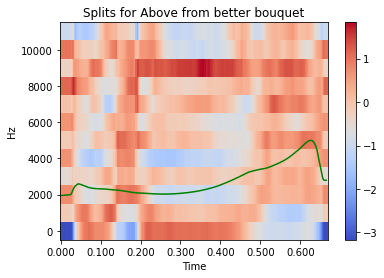

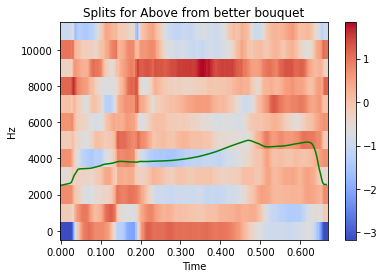

In [ ]:
plot_timeseries_on_mfcc(clip["mfcc"],scores1,sr,title="Splits for "+word+" from better bouquet",line_color='green')
plot_timeseries_on_mfcc(clip["mfcc"],scores2,sr,title="Splits for "+word+" from better bouquet",line_color='green')

### Recursive Segmentation from better Bouquet

Refined segmentation Level 1 complete
Pruned segmentation Level 1 complete
Refined segmentation Level 2 complete
Pruned segmentation Level 2 complete
Refined segmentation Level 3 complete
Pruned segmentation Level 3 complete
Refined segmentation Level 4 complete
Pruned segmentation Level 4 complete
Refined segmentation Level 5 complete
Pruned segmentation Level 5 complete


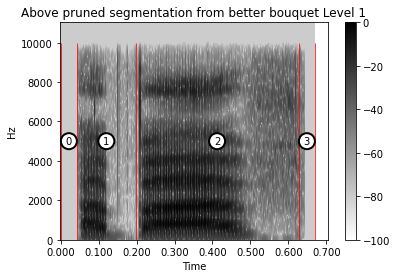

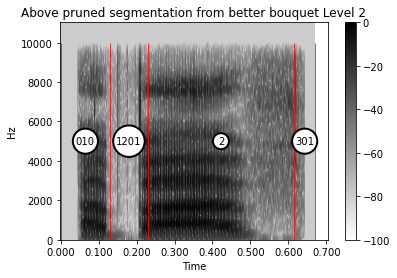

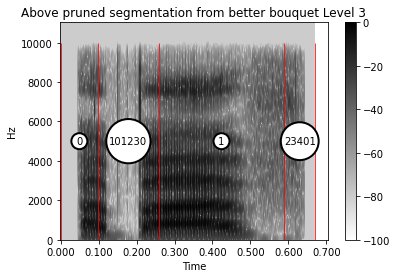

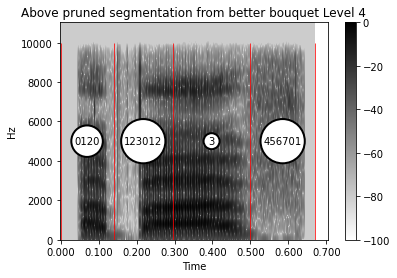

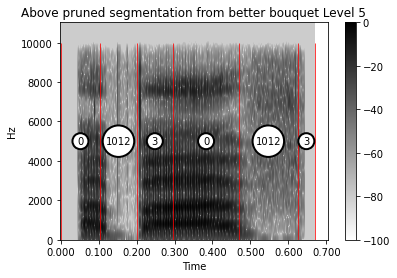

In [ ]:
word = "Above"
clip = clip_dict[word]

seg = get_even_segments(clip["frames"].shape[0],w,n_segments=1)

prune_zeal = 1.5

refined_seg1 = recurrence_refine(seg,clip["frames"],combined_narr_seg_split,zeal=100,text_method='raw_index')
#plot_segments_on_spectrogram(clip["fourier"],refined_seg1,sr,title=f"{word} refined segmentation from better bouquet Level 1",line_color='red')
print("Refined segmentation Level 1 complete")
pruned_seg1 = recurrence_prune(refined_seg1,clip["frames"],combined_narr_seg_split,zeal=prune_zeal,text_method='join')
plot_segments_on_spectrogram(clip["fourier"],pruned_seg1,sr,title=f"{word} pruned segmentation from better bouquet Level 1",line_color='red')
print("Pruned segmentation Level 1 complete")
refined_seg2 = recurrence_refine(pruned_seg1,clip["frames"],combined_narr_seg_split,zeal=100,text_method='raw_index')
#plot_segments_on_spectrogram(clip["fourier"],refined_seg2,sr,title=f"{word} refined segmentation from better bouquet Level 2",line_color='red')
print("Refined segmentation Level 2 complete")
pruned_seg2 = recurrence_prune(refined_seg2,clip["frames"],combined_narr_seg_split,zeal=prune_zeal,text_method='join')
plot_segments_on_spectrogram(clip["fourier"],pruned_seg2,sr,title=f"{word} pruned segmentation from better bouquet Level 2",line_color='red')
print("Pruned segmentation Level 2 complete")
refined_seg3 = recurrence_refine(pruned_seg2,clip["frames"],combined_narr_seg_split,zeal=100,text_method='raw_index')
#plot_segments_on_spectrogram(clip["fourier"],refined_seg3,sr,title=f"{word} refined segmentation from better bouquet Level 2",line_color='red')
print("Refined segmentation Level 3 complete")
pruned_seg3= recurrence_prune(refined_seg3,clip["frames"],combined_narr_seg_split,zeal=prune_zeal,text_method='join')
plot_segments_on_spectrogram(clip["fourier"],pruned_seg3,sr,title=f"{word} pruned segmentation from better bouquet Level 3",line_color='red')
print("Pruned segmentation Level 3 complete")
refined_seg4 = recurrence_refine(pruned_seg3,clip["frames"],combined_narr_seg_split,zeal=100,text_method='raw_index')
#plot_segments_on_spectrogram(clip["fourier"],refined_seg4,sr,title=f"{word} refined segmentation from better bouquet Level 2",line_color='red')
print("Refined segmentation Level 4 complete")
pruned_seg4= recurrence_prune(refined_seg4,clip["frames"],combined_narr_seg_split,zeal=prune_zeal,text_method='join')
plot_segments_on_spectrogram(clip["fourier"],pruned_seg4,sr,title=f"{word} pruned segmentation from better bouquet Level 4",line_color='red')
print("Pruned segmentation Level 4 complete")
refined_seg5 = recurrence_refine(pruned_seg4,clip["frames"],combined_narr_seg_split,zeal=100,text_method='raw_index')
#plot_segments_on_spectrogram(clip["fourier"],refined_seg5,sr,title=f"{word} refined segmentation from better bouquet Level 2",line_color='red')
print("Refined segmentation Level 5 complete")
pruned_seg5 = recurrence_prune(refined_seg5,clip["frames"],combined_narr_seg_split,zeal=prune_zeal,text_method='join')
plot_segments_on_spectrogram(clip["fourier"],pruned_seg5,sr,title=f"{word} pruned segmentation from better bouquet Level 5",line_color='red')
print("Pruned segmentation Level 5 complete")

refined_seg6 = recurrence_refine(pruned_seg5,clip["frames"],combined_narr_seg_split,zeal=100,text_method='raw_index')
#plot_segments_on_spectrogram(clip["fourier"],refined_seg5,sr,title=f"{word} refined segmentation from better bouquet Level 2",line_color='red')
print("Refined segmentation Level 5 complete")
pruned_seg6 = recurrence_prune(refined_seg5,clip["frames"],combined_narr_seg_split,zeal=prune_zeal,text_method='join')
plot_segments_on_spectrogram(clip["fourier"],pruned_seg5,sr,title=f"{word} pruned segmentation from better bouquet Level 5",line_color='red')
print("Pruned segmentation Level 5 complete")

## Recurrence score temporal bias testing

Sample rate = 22050
Frame Width = 2.902 ms
Clip length = 25.522 s
Number of segments: 255
Number of intervals in bouquet #1 = 255
Number of 1-segment intervals = 255
Number of 2-segment intervals = 0
Number of 3-segment intervals = 0
Number of 4-segment intervals = 0
Number of 5-segment intervals = 0
Number of intervals in bouquet #2 = 254
Number of 1-segment intervals = 0
Number of 2-segment intervals = 254
Number of 3-segment intervals = 0
Number of 4-segment intervals = 0
Number of 5-segment intervals = 0
Number of intervals in bouquet #3 = 253
Number of 1-segment intervals = 0
Number of 2-segment intervals = 0
Number of 3-segment intervals = 253
Number of 4-segment intervals = 0
Number of 5-segment intervals = 0
Number of intervals in bouquet #4 = 251
Number of 1-segment intervals = 0
Number of 2-segment intervals = 0
Number of 3-segment intervals = 0
Number of 4-segment intervals = 0
Number of 5-segment intervals = 251
Number of intervals in bouquet #5 = 507
Number of 1-segment in

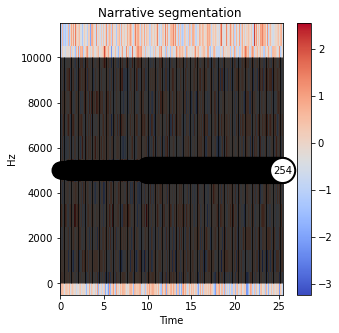

In [147]:
### Generate Bouquets
#### Segmentation
index = 3

sub_narr_len = len(sub_narrs_frames[index])

res = 3
sr = sr
hop = 2**(9-res)
w = hop/sr

sig_figs = 3

print(f"Sample rate = {sr}")
print(f"Frame Width = {round(1000*w,sig_figs)} ms")
print(f"Clip length = {round(w*sub_narr_len,sig_figs)} s")
even_segmentation = get_even_segments(sub_narr_len,frame_w=w,seg_ms=100,clip_last = False)
print(f"Number of segments: {len(even_segmentation)}")

plot_segments_on_mfcc(np.transpose(sub_narrs_frames[index]),even_segmentation,sr,title=f"Narrative segmentation ",line_color='black',complete = False)
#### Bouquet

narr_bouquet_list = []
#n_iter_list = [[2],[3],[4],[5],[2,3],[3,4],[4,5],[2,3,4],[3,4,5],[2,3,4,5]]
n_iter_list = [[1],[2],[3],[5],[2,3],[2,5]]

for n_iter in n_iter_list:
    narr_bouquet_list.append(get_bouquet(even_segmentation,n_iter=n_iter,text_method = 'count'))

for j,narr_bouquet in enumerate(narr_bouquet_list):
    print(f'Number of intervals in bouquet #{j+1} = {len(narr_bouquet_list[j])}')
    for i in [1,2,3,4,5]:
        print(f'Number of {i}-segment intervals = {len([s for s in narr_bouquet_list[j] if s["text"] == str(i)])}')
#### Split MFCC

narr_bouquet_mfcc_list = []
for narr_bouquet in narr_bouquet_list:
    narr_bouquet_mfcc_list.append(split_frames(narr_bouquet,sub_narrs_frames[index]))
    print(len(narr_bouquet_mfcc_list[-1]))
    print(set([frames.shape[0] for frames in narr_bouquet_mfcc_list[-1]]))

In [196]:
def recurrence_square(mfcc,comp_frames_list,pixel=10,band=550):
  mfcc_len = mfcc.shape[0]
  triangle_list = []
  for w in range(0,mfcc_len,pixel):
    row_list = []
    for v in range(0,mfcc_len,pixel):
      if w<=v or w>v+band:
        d = 0
      else:
        interval = np.split(mfcc,[v,w])[1]
        #d = w-v
        d = recurrence_score(interval,comp_frames_list)
      row_list.append(d)
    #print(f'Row {w} complete')
    row = np.array(row_list)
    triangle_list.append(row)
  triangle = np.stack(triangle_list,axis=1)
  return triangle

In [204]:
my_square_list = []
word = "Narr "+str(index)
pixel = 2

res = 3
sr = sr
hop = 2**(9-res)
w = hop/sr
band_ms = 1000

band = int(round(0.001*band_ms/w,0))

clip_frames = np.transpose(norm_array_hor(narrative_data[index]["mfcc"]["12"],narr_scaler))
#clip_frames = clip_dict[word]["frames"]

print(f'Length: {round(clip_frames.shape[0]*w,3)}s')

for i,bouquet in enumerate(narr_bouquet_mfcc_list):
    my_square = recurrence_square(clip_frames,bouquet,pixel=pixel,band=band)
    my_square_list.append(my_square)
    print(f'{n_iter_list[i]} square for {word} complete')

Length: 2.194s
[1] square for Narr 3 complete
[2] square for Narr 3 complete
[3] square for Narr 3 complete
[5] square for Narr 3 complete
[2, 3] square for Narr 3 complete
[2, 5] square for Narr 3 complete


In [225]:
my_triangle_list = []
for i,my_square in enumerate(my_square_list):
    unpack = list(my_square)
    triangle_list = []
    for w,row in enumerate(unpack):
        row_list = []
        for v,val in enumerate(row):
            d = val*np.log((v-w)+1)
            row_list.append(d)
        #print(f'Row {w} complete')
        triangle_list.append(np.array(row_list))
    my_triangle = np.transpose(np.stack(triangle_list,axis=1))
    my_triangle_list.append(my_triangle)

/var/folders/51/7fj4w38x7ydg8ckmrw3l6b7w0000gn/T/ipykernel_35277/3502936067.py:8: RuntimeWarning: divide by zero encountered in log
  d = val*np.log((v-w)+1)
/var/folders/51/7fj4w38x7ydg8ckmrw3l6b7w0000gn/T/ipykernel_35277/3502936067.py:8: RuntimeWarning: invalid value encountered in double_scalars
  d = val*np.log((v-w)+1)
/var/folders/51/7fj4w38x7ydg8ckmrw3l6b7w0000gn/T/ipykernel_35277/3502936067.py:8: RuntimeWarning: invalid value encountered in log
  d = val*np.log((v-w)+1)


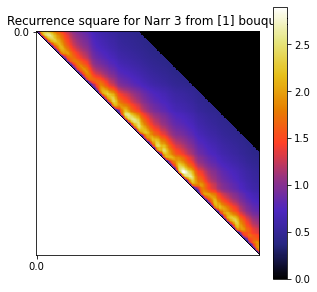

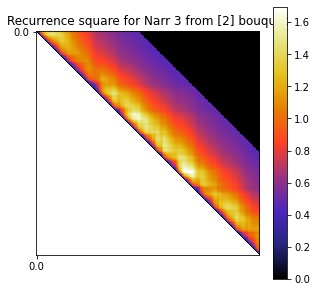

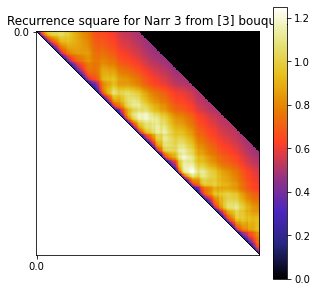

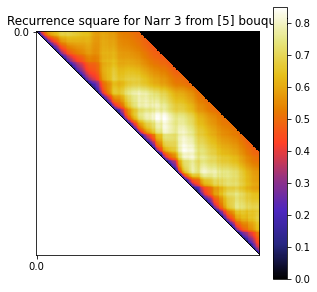

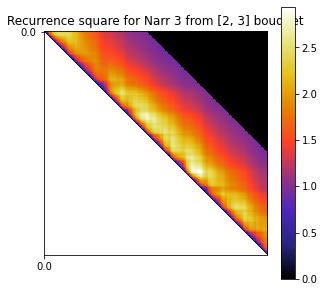

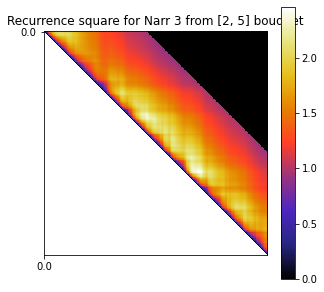

: 

In [227]:
res = 3
sr = sr
hop = 2**(9-res)
w = hop/sr
dur = (1/pixel)*w*clip_frames.shape[0]*w
for i,my_triangle in enumerate(my_triangle_list):
    title = "Recurrence square for "+word+" from "+str(n_iter_list[i])+" bouquet"
    plot_sound_square(my_triangle,dur=dur,sr = sr,colors='CMRmap',size=5,heat_max=None,title=title)